In [1]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [2]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [3]:
measurements_used = 150
time_series_used = 10
# energy_per_time = 1000
generate_graphs = False
show_plots = False

get_timeseries = False
get_measurements = True

In [4]:
# exp_name = "compiler"
exp_name = "measuring_instrument"
# exp_name = "run-many-times"
# exp_name = "cores"

In [5]:
used_dut_name = [
    'workstationtwo',
    'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

# used_os_names = [
#     windows, 
#     linux
# ]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [6]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_os_names = [
        windows, 
        linux
    ]
    
    used_mi_names = [
        ipg, scaphandre, lhm, plug, rapl, clamp, rapl
        # clamp
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        # lhm#, plug
        # lhm #clamp
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]
    
if exp_name == "run-many-times":
    experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    
    used_os_names = [
        windows, 
    ]
    
    used_dut_name = [
        'workstationtwo',
    ]
    
    used_test_case_names = [
        'mandelbrot.exe',
    ]
    
    used_mi_names = [
        clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]

if exp_name == 'cores':
    experiment_name = "same-one-api-compiler-different-cores"
    experiment_number = 3
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg #, clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    used_test_case_names = [
        'nbody.exe',
        'spectral-norm.exe',
        # 'idle-case.exe'
    ]
    
    used_thread = [
        'single-threaded'
    ]
    
    used_allocated_cores = [
        ['0'], 
        ['1'], 
        ['2'],
        ['3'],
        ['4'],
        ['5'],
        ['6'],
        ['7'],
        ['8'],
        ['9'],
    ]
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = ["", "180000000", "18000"]


used_mi_names.sort()
used_compilers.sort()

In [7]:
used_test_case_names

['fannkuch-redux.exe', 'mandelbrot.exe']

### DUTs

In [8]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [9]:
dut = rep.get_devices_under_test(db)
dut.shape

(9, 4)

In [10]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut.shape

(4, 4)

### Test Cases

In [11]:
tc = rep.get_test_cases(db)

tc.shape

(30, 8)

In [12]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [13]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [14]:
used_test_case_parameters

"','12','64000"

### Measuring Instruments

In [15]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [16]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [17]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [18]:
config = rep.get_configurations(db)

config.shape

(15, 5)

In [19]:
config.shape

(15, 5)

In [20]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            # f"{ALLOCATED_CORES} in ('[1]')")
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
                            # f"CAST({ALLOCATED_CORES} as CHAR) = [{used_allocated_cores_str}]")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


### Experiment Names

In [21]:
exp = rep.get_distinct_experiments(db)

exp.shape

(8, 2)

## Used Things

In [22]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
4,5,workstationtwo,win32nt,prod
8,9,workstationtwo,unix,prod


In [23]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [24]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
1,4,rapl,100
4,8,plug,200
5,9,lhm,100
7,12,scaphandre,100
14,19,clamp,100


In [25]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [26]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [27]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

In [28]:
# [x for x in time_series[0]["fannkuch-redux.exe.rapl.workstationone.all.intel-one-api.unix"].iterrows()]

In [29]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            table.plot(x="ElapsedTime", y="ProcessorPowerInWatt")
        if "rapl" in key:
            table['rapl_column'] = df_util.get_rapl_column(table, "total_core")
            table.plot(x="ElapsedTime", y="rapl_column")
        plot.show()

In [30]:
used_configs.shape, used_dut.shape, used_mi.shape, used_tc.shape, used_idle_case.shape


((1, 5), (4, 4), (6, 3), (2, 8), (1, 8))

In [31]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [32]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_watt_consumption = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption
    )

Y - fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.ipg.100.4
Y - mandelbrot.exe.win32nt.workstationone.all.intel-one-api.ipg.100.22
Y - fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.plug.200.4
Y - mandelbrot.exe.win32nt.workstationone.all.intel-one-api.plug.200.22
Y - fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.lhm.100.4
Y - mandelbrot.exe.win32nt.workstationone.all.intel-one-api.lhm.100.22
Y - fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre.100.4
Y - mandelbrot.exe.win32nt.workstationone.all.intel-one-api.scaphandre.100.22
Y - fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.clamp.100.4
Y - mandelbrot.exe.win32nt.workstationone.all.intel-one-api.clamp.100.22
Y - fannkuch-redux.exe.unix.workstationone.all.intel-one-api.rapl.100.4
Y - mandelbrot.exe.unix.workstationone.all.intel-one-api.rapl.100.22
Y - fannkuch-redux.exe.unix.workstationone.all.intel-one-api.plug.200.4
Y - mandelbrot.exe.unix.workstationone.all

In [33]:
min(cpu_dynamic_energy_consumption['mandelbrot.exe.unix.workstationtwo.all.intel-one-api.rapl'])

184.4954264792255

In [34]:
if get_measurements:
    df_util.trim_dataframes(
        measurements_used,
        dram_energy_results,
        cpu_energy_results,
        gpu_energy_results,
        duration_results,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        temperature_end,
        temperature_begin,
        cpu_dynamic_energy_watt_consumption
    )

In [35]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [36]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_energy_results = convert_to_series(dram_energy_results)
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_energy_results = convert_to_series(cpu_energy_results)
    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_energy_results = convert_to_series(gpu_energy_results)
    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_results = convert_to_series(duration_results)
    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_energy_consumption = convert_to_series(dram_dynamic_energy_consumption)
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_energy_consumption = convert_to_series(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))
    
    cpu_dynamic_energy_watt_consumption = convert_to_series(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = pd.DataFrame(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = cpu_dynamic_watt_df.reindex(columns=sorted(cpu_dynamic_watt_df.columns))

    gpu_dynamic_energy_consumption = convert_to_series(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_consumption_results = convert_to_series(idle_cpu_consumption_results)
    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin = convert_to_series(temperature_begin)
    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end = convert_to_series(temperature_end)
    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))




In [37]:
if get_measurements:
    for column in duration_df.columns:
        duration_df[column] = duration_df[column] / 1000

In [38]:
max(list(cpu_df.max()))

2417.3855419833726

In [39]:
if get_measurements and show_plots:
    test_boxplot = dram_df.boxplot(figsize=(15,1), rot=75, column=[dram_df.columns[0]])
    test_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()
    
    
    # print("Combined DRAM Energy Consumption in Joules")
    # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=85)
    # # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=['fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt'])
    # dram_boxplot.plot()
    # plot.ylim(0, 40)
    # plot.show()

    print("Combined CPU Energy Consumption in Joules")
    cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=85)
    cpu_boxplot.plot()
    cpu_boxplot
    plot.ylim(0,max(list(cpu_df.max())) + 200)
    plot.show()

    # print("Combined GPU Energy Consumption in Joules")
    # gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=85)
    # gpu_boxplot.plot()
    # plot.ylim(0,50)
    # plot.show()

    print("Duration of Test Case")
    duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=85)
    duration_boxplot.plot()
    # plot.ylim(0,40)
    plot.show()

In [40]:
cpu_dynamic_watt_df

,fannkuch-redux.exe.unix.workstationone.all.intel-one-api.plug,fannkuch-redux.exe.unix.workstationone.all.intel-one-api.rapl,fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.plug,fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.rapl,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.clamp,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.ipg,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.lhm,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.plug,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre_isolated,...,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.lhm,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.plug,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.scaphandre,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.scaphandre_isolated,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.ipg,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.lhm,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.plug,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.scaphandre,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.scaphandre_isolated
0,9.498124,7.873743,9.245749,7.414316,19.702026,25.366623,24.574888,30.947800,26.126773,35.146539,...,29.938944,35.278368,31.016987,38.711745,16.754816,13.951564,14.075042,21.853908,15.273762,18.920371
1,9.458680,7.961114,8.565417,6.200268,18.996256,24.943718,24.848498,29.223663,26.180449,35.311892,...,30.029116,34.852826,31.101604,38.738161,16.559052,13.909390,14.241368,23.268449,14.070172,17.135909
2,9.486831,7.928768,8.677620,6.922998,20.106648,24.657315,23.534719,28.566533,25.642838,34.775871,...,29.938294,34.644347,31.130345,38.715568,15.041084,14.131850,14.088020,21.577146,15.113268,18.661187
3,9.558885,8.107137,8.655598,7.273826,11.041833,24.655312,24.886042,28.941345,25.591672,34.672798,...,29.961075,34.157639,31.106114,38.667900,15.805591,13.896443,14.106719,20.610589,13.995773,17.022066
4,9.535901,7.921269,9.206552,7.088184,20.064758,25.065213,24.418897,29.366533,25.547969,34.607933,...,29.952303,34.946506,31.233535,39.009639,15.689859,14.314751,13.944911,20.752881,15.326771,19.040994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.481529,NaN,NaN,19.685691,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.121923,NaN,NaN,19.637097,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16.743694,NaN,NaN,20.998011,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.733554,NaN,NaN,21.212181,NaN,NaN


In [41]:
cpu_dynamic_df

,fannkuch-redux.exe.unix.workstationone.all.intel-one-api.plug,fannkuch-redux.exe.unix.workstationone.all.intel-one-api.rapl,fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.plug,fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.rapl,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.clamp,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.ipg,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.lhm,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.plug,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre,fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre_isolated,...,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.lhm,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.plug,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.scaphandre,mandelbrot.exe.win32nt.workstationone.all.intel-one-api.scaphandre_isolated,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.ipg,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.lhm,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.plug,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.scaphandre,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.scaphandre_isolated
0,836.672012,310.942000,720.363521,255.044009,673.432587,536.570342,515.322651,807.434881,550.562032,685.198088,...,425.871984,471.873613,445.395989,561.694902,768.332631,333.179674,330.151399,724.789872,363.110161,408.255693
1,835.471689,313.598923,701.751243,224.146689,659.761012,528.289713,520.637437,774.077630,551.608466,688.421734,...,427.170561,465.779046,446.623744,562.078185,764.098470,332.274151,333.675478,755.345082,337.139622,369.751338
2,836.328358,312.615283,704.820868,242.540047,681.270601,522.681844,495.117773,761.363992,541.127509,677.971754,...,425.862628,462.793227,447.040772,561.750368,731.266501,337.050595,330.426366,718.811588,359.647097,402.663136
3,838.521015,318.039434,704.218401,251.468559,505.674612,522.642616,521.366708,768.615571,540.129985,675.962290,...,426.190699,455.822627,446.689183,561.058730,747.801952,331.996146,330.822552,697.933178,335.534276,367.294891
4,837.821608,312.387259,719.291178,246.744003,680.459127,530.668640,512.292592,776.841765,539.277991,674.697709,...,426.064367,467.120714,448.538021,566.017248,745.298789,340.977684,327.394201,701.006806,364.253964,410.858450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,740.792843,NaN,NaN,677.954634,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,603.241634,NaN,NaN,676.904974,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,768.092065,NaN,NaN,706.301794,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,616.470534,NaN,NaN,710.928052,NaN,NaN


In [42]:
if get_measurements and show_plots:
    # print("Dynamic DRAM Energy Consumption in Watts")
    # dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_dram_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()

    print("Dynamic CPU Energy Consumption in Joiles")
    dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=85)
    dynamic_cpu_boxplot.plot()
    plot.ylim(-100, 100)
    plot.show()
    
    print("Dynamic CPU Energy Consumption in Watts")
    dynamic_watt_cpu_boxplot = cpu_dynamic_watt_df.boxplot(figsize=(15,5), rot=85)
    dynamic_watt_cpu_boxplot.plot()
    plot.ylim(0,50)
    plot.show()
    
    

    # print("Dynamic GPU Energy Consumption in Watts")
    # dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_gpu_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()


In [43]:
def list_to_label(lst, mapper):
    if len(lst) == 1:
        return mapper[lst[0]]
    elif len(lst) == 2:
        return f"{mapper[lst[0]]} and {mapper[lst[1]]}"
    else:
        return ", ".join([mapper[x] for x in lst[:-1]]) + f" and {mapper[lst[-1]]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [44]:
dut_name_mapper = {
    "workstationone" : "DUT 1",
    "workstationtwo" : "DUT 2"
}

compiler_mapper = {
    "clang" : "Clang",
    "min-gw" : "MinGW",
    "intel-one-api" : "oneAPI",
    "msvc" : "MSVC"
}

test_case_mapper = {
    "fannkuch-redux.exe" : "FR",
    "mandelbrot.exe" : "MB",
    "nbody.exe" : "NB",
    "spectral-norm.exe" : "SN"
}

mi_mapper = {
    "ipg" : "IPG",
    "lhm" : "LHM",
    "clamp" : "Clamp",
    "plug" : "Plug",
    "scaphandre" : "SCAP",
    "scaphandre_isolated" : "SCAPI",
    "rapl" : "RAPL"
}

os_mapper = {
    "unix" : 'LIN',
    "win32nt" : "WIN"
}

In [45]:
box_plot_raw_data = [
    {
        "data" : cpu_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Average Energy Consumption (Joules)"
    },
    {
        "data" : cpu_dynamic_df,
        "name" : "CPU",
        "data_type" : "DEC",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 1000,
        "xlabel" : "Average DEC (Joules)"
    },
    {
        "data" : cpu_dynamic_watt_df,
        "name" : "CPU",
        "data_type" : "DEC per second",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Average DEC (Watts)"
    },
    # {
    #     "data" : dram_dynamic_df,
    #     "name" : "DRAM",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : dram_df,
    #     "name" : "DRAM",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 40,
    #     "xlabel" : "Total Energy Consumption (Joules)"
    # },
    # {
    #     "data" : gpu_dynamic_df,
    #     "name" : "GPU",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : gpu_df,
    #     "name" : "GPU",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 50,
    #     "xlabel" : "Total Energy Consumption (Watt)"
    # },
    {
        "data" : duration_df,
        "name" : "Runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

In [46]:
if generate_graphs and get_measurements:
    for plot_data in box_plot_raw_data:
        print("start")
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        plot.clf()
        # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
        
        if name == 'Runtime':
            title = f"The average duration"
        else:
            title = f"The {data_type} of the {name}"
        
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(
            data, 
            used_test_case_names, 
            used_mi_names, 
            used_dut_name, 
            used_allocated_cores, 
            used_compiler_str, 
            used_os_names,
            dut_name_mapper,
            compiler_mapper,
            test_case_mapper,
            mi_mapper,
            os_mapper
            )
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}".lower()
        
        c_test_cases = list_to_label(used_test_case_names, test_case_mapper)
        c_compiler = list_to_label(used_compilers, compiler_mapper)
        c_duts = list_to_label(used_dut_name, dut_name_mapper)
        c_measuring_instrument = list_to_label(used_mi_names, mi_mapper)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        # print(data)
        path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [47]:
# \addplot[mark=none, blue] coordinates {(1000,0) (1000,5)};

In [48]:
def remove_n_percent(df, column, percent):
    data_to_order = df[column]

    list(data_to_order).sort()
    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    percent = 20

    n = len(data_to_order)
    outliers = int(n*percent/100) #may want some rounding logic if n is small
    trimmed_data = data_to_order[outliers: n-outliers]
    
    return trimmed_data

def remove_n_first(df, column, n):
    data_to_order = df[column]

    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    trimmed_data = data_to_order[n:]
    
    return trimmed_data

In [49]:
# percent = 20
# n = len(used_df['spectral-norm.exe.win32nt.workstationtwo.[2].intel-one-api.ipg'])
# outliers = n*percent/100 #may want some rounding logic if n is small
# trimmed_data = sorted_data[outliers: n-outliers]

In [50]:
def  remove_outliers_z_score(df, column, limit):
    df['z_score'] = np.abs((df[column] - df[column].mean()) / df[column].std())

    # identify outliers as data points with z-score > 3
    outliers = df[column][df['z_score'] > limit]
    
    return [
        x for x in list(df[column]) if x not in list(outliers)
    ]

In [51]:
len(cpu_dynamic_watt_df['mandelbrot.exe.unix.workstationone.all.intel-one-api.plug']), len(remove_outliers_z_score(cpu_dynamic_watt_df, 'mandelbrot.exe.unix.workstationone.all.intel-one-api.plug', 2))

(1000, 975)

In [52]:
remove_outliers_z_score(cpu_dynamic_watt_df, 'mandelbrot.exe.unix.workstationone.all.intel-one-api.plug', 3)

[35.22470098167937,
 34.14560493648154,
 36.59244623078076,
 34.984870473204744,
 33.39831133341996,
 34.96948585782015,
 36.99850683684118,
 35.58389008104796,
 35.72047205111374,
 34.51960942902793,
 35.8515371398715,
 32.98948894710028,
 34.59565478692998,
 34.43606094939519,
 35.78805399380381,
 34.49023770484349,
 34.21188196745759,
 33.556415188652004,
 33.61196658772429,
 35.868401045196826,
 35.36104127210272,
 35.29908315214167,
 32.37575097634943,
 32.83261822095265,
 32.48820380653783,
 35.9472514255857,
 34.43973938706224,
 34.65494623078026,
 36.61264825098234,
 33.613425251759445,
 35.400413544365314,
 34.72442870613626,
 37.271234109568304,
 35.09435151112884,
 37.305334608225614,
 35.02479295382468,
 35.29367197133221,
 35.788086847473345,
 32.23946817435421,
 35.762900776235334,
 37.60456744290145,
 33.936602074936324,
 35.841962671785986,
 35.60558338264574,
 34.20871946031328,
 34.02383013350185,
 36.4422778806122,
 35.160755016966554,
 35.54733866658912,
 35.7626482

In [53]:
np.abs((cpu_dynamic_watt_df[column] - cpu_dynamic_watt_df[column].mean()) / cpu_dynamic_watt_df[column].std())

0      0.905854
1      1.137756
2      0.633347
3      1.264080
4      0.995860
         ...   
995         NaN
996         NaN
997         NaN
998         NaN
999         NaN
Name: mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.scaphandre, Length: 1000, dtype: float64

In [54]:
cpu_dynamic_watt_df['mandelbrot.exe.unix.workstationone.all.intel-one-api.plug']

0      35.224701
1      34.145605
2      36.592446
3      34.984870
4      33.398311
         ...    
995          NaN
996          NaN
997          NaN
998          NaN
999          NaN
Name: mandelbrot.exe.unix.workstationone.all.intel-one-api.plug, Length: 1000, dtype: float64

,0,1,2,3,4
,with,without,z,percent,count
fannkuch-redux.exe.unix.workstationone.all.intel-one-api.plug,24.6,4.3,4.6,36.9,413.0
fannkuch-redux.exe.unix.workstationone.all.intel-one-api.rapl,74.8,52.5,35.2,63.9,582.0
fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.plug,979.1,738.1,431.4,1099.0,460.0
fannkuch-redux.exe.unix.workstationtwo.all.intel-one-api.rapl,1342.1,1298.8,753.3,1285.4,462.0
fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.clamp,55567.9,16908.8,19025.4,49174.2,680.0
fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.ipg,899.2,714.4,461.2,838.5,751.0
fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.lhm,729.5,604.2,387.7,662.8,592.0
fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.plug,2714.6,2474.6,1594.3,2899.7,751.0
fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.scaphandre,520.4,459.7,291.3,477.0,502.0


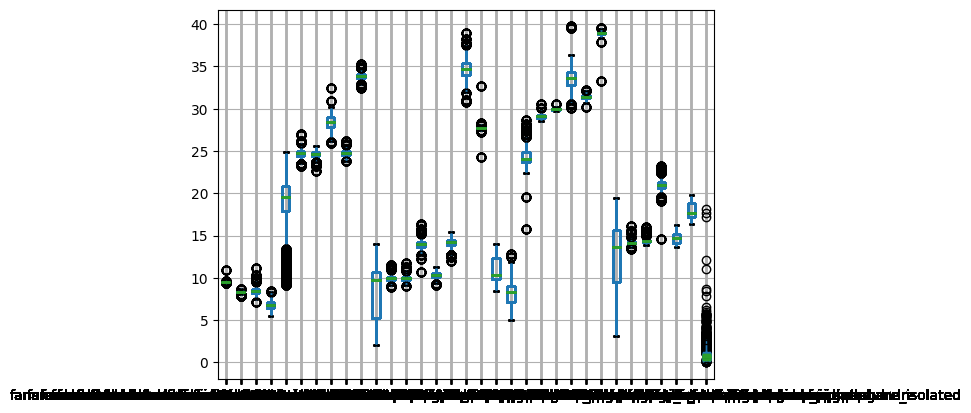

In [55]:
cochrans_data = {
    "" : ["with", "without", 'z', "percent", "count"]
}

if get_measurements:
    Z = 1.96
    E = 0.03

    # Z = 2.58
    # E = 0.01

    include_outliers = False

    used_df = cpu_dynamic_watt_df

    for column in used_df.columns:
        used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
        used_df_without_n_percent = remove_n_percent(used_df, column, 20)
        used_df_without_z_score_outliers = remove_outliers_z_score(used_df, column, 1.5)
        
        
        
        
        # used_df_remove_n = remove_n_first(used_df, column, 1000)
        # pd_removed = pd.DataFrame({column : used_df_remove_n})
        # used_df_remove_n = math_util.exclude_outliers(pd_removed, column)
        
        
        current_count = used_df[column].count()
        
        values = used_df_without_outlisers
        n_zero_without = math_util.get_cochran(values, Z, E)
        
        values = used_df_without_z_score_outliers
        n_zero_without_z_outliers = math_util.get_cochran(values, Z, E)
        
        # values = used_df_remove_n
        # n_zero_removed = math_util.get_cochran(values, Z, E)
        # print(n_zero_removed)
        
        values = used_df_without_n_percent
        n_zero_percent = math_util.get_cochran(values, Z, E)
        
        values = list(used_df[column])
        n_zero = math_util.get_cochran(values, Z, E)
        
        cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1), round(n_zero_without_z_outliers, 1), round(n_zero_percent, 1), current_count]

pd.DataFrame(cochrans_data).T